In [1]:
%load_ext autoreload
%autoreload 2
from utility.utils import * 
from utility.plots import *
from pathlib import *

Here we will use fixed images from https://www.kaggle.com/c/data-science-bowl-2018/discussion/50518

In [5]:
MAIN_PATH = '../data/ds_bowl_2018/kaggle_fixed'

In [6]:
TRAIN_DIRS = list(Path(MAIN_PATH).iterdir())

In [7]:
i = 0
IMAGE = list((TRAIN_DIRS[i]/'images').iterdir())
MASKS = list((TRAIN_DIRS[i]/'masks').iterdir())

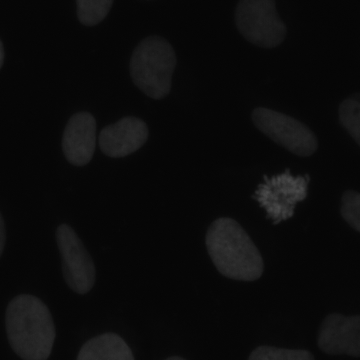

In [8]:
Image.open(IMAGE[0])

In [9]:
MASKS[0]

PosixPath('../data/ds_bowl_2018/kaggle_fixed/58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd/masks/9047c2560c1fa473a9912f2019c8109329e2f8ee0403a252cc8d70e8872efb34.png')

In [10]:
masks = [open_image(str(mask_path)) for mask_path in MASKS]

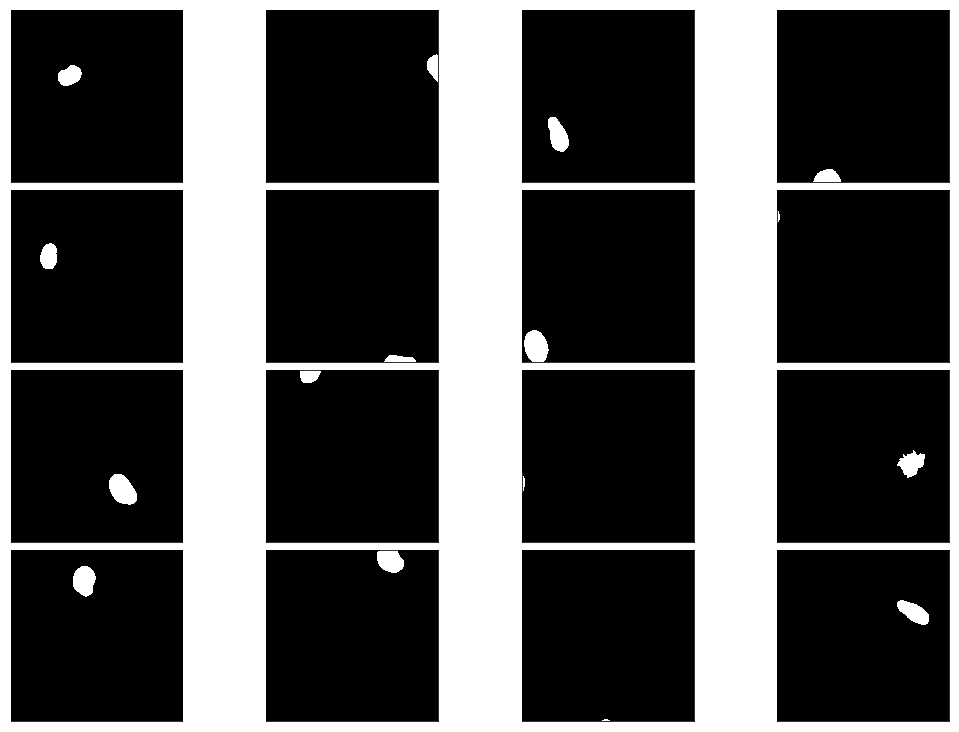

In [11]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10))
for i,ax in enumerate(axes.flat): show_img(masks[i], ax=ax)
plt.tight_layout(pad=0.1)

In [12]:
all_masks = np.sum(np.array(masks), 0)

In [13]:
gray = cv2.cvtColor(all_masks, cv2.COLOR_BGR2GRAY)

(t, binary) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

In [14]:
(binary)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
# contour for the mask i = 0
(_, contours, _) = cv2.findContours(binary.astype(np.uint8), 
                           cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

In [19]:
contoured_mask = cv2.drawContours(all_masks, contours, -1, (0, 0, 255), 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


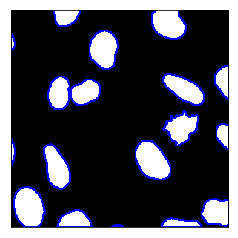

In [20]:
show_img(contoured_mask)

In [21]:
out = np.clip(np.max(contoured_mask, 2), 0, 2)

In [22]:
np.unique(out)

array([0., 1., 2.], dtype=float32)

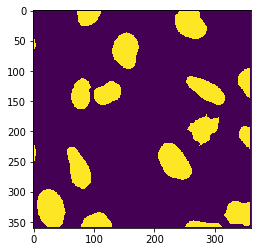

In [23]:
# multilcass setting classes 0, 1, 2
plt.imshow(out==1)

### Pipeline: Multiclass Target Generation

In [24]:
MASKS[0]

PosixPath('../data/ds_bowl_2018/kaggle_fixed/58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd/masks/9047c2560c1fa473a9912f2019c8109329e2f8ee0403a252cc8d70e8872efb34.png')

In [25]:
# collect masks from mask_path of that image
masks = [open_image(str(mask_path)) for mask_path in MASKS]
# combine all masks
all_masks = np.sum(np.array(masks), 0)

In [26]:
def mclass_target_gen(mask_path):
    """takes mask paths and return mclass array"""
    # read mask
    mask = open_image(str(mask_path))
    # from BGR to GRAY
    gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    # binarize for contouring
    (t, binary) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    # find contours with RETR_EXTERNAL method
    (_, contours, _) = cv2.findContours(binary.astype(np.uint8), 
                               cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    # draw contours on original image
    contoured_mask = cv2.drawContours(mask, contours, -1, (0, 0, 255), 2)
    # generate 1 channel target array 0: background, 1: inside, 2: contour 
    out = np.clip(np.max(contoured_mask, 2), 0, 2)
    return out

In [27]:
# given training sample i
i = 1
IMAGE = list((TRAIN_DIRS[i]/'images').iterdir())
MASKS = list((TRAIN_DIRS[i]/'masks').iterdir())

In [28]:
all_masks = [mclass_target_gen(MASK) for MASK in MASKS]

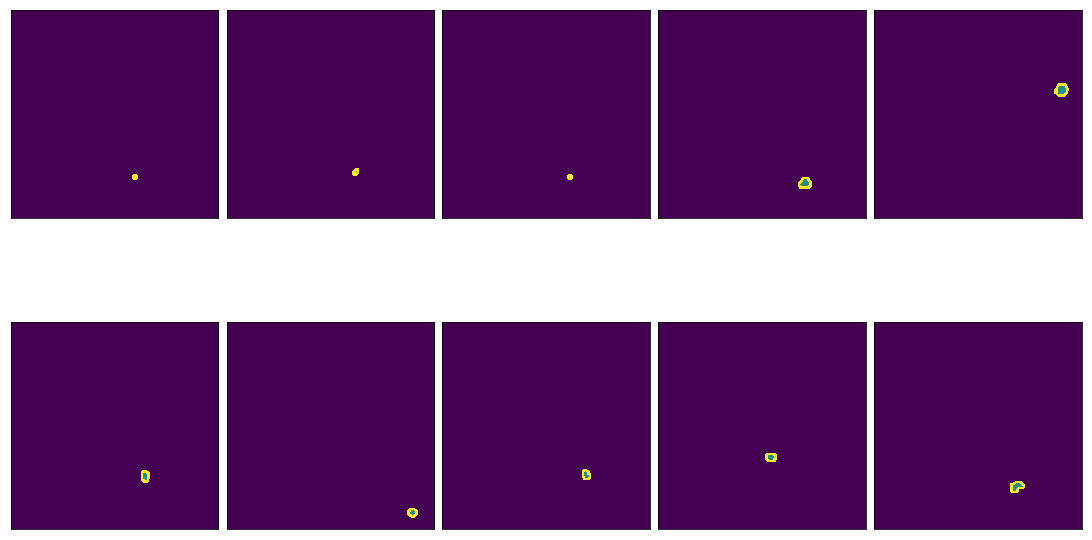

In [29]:
fig, axes = plt.subplots(2, 5, figsize=(15, 10))
for i,ax in enumerate(axes.flat): show_img(all_masks[i], ax=ax)
plt.tight_layout(pad=0.1)

### Create Multiclass Target Files

In [30]:
from concurrent.futures import ThreadPoolExecutor

In [31]:
# sample i
i = 0
IMAGE = list((TRAIN_DIRS[i]/'images').iterdir())
MASKS = list((TRAIN_DIRS[i]/'masks').iterdir())

In [32]:
MASKS[0].parent.parent/'mclass_target.png'

PosixPath('../data/ds_bowl_2018/kaggle_fixed/58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd/mclass_target.png')

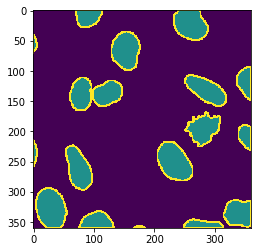

In [33]:
out = np.sum([mclass_target_gen(MASK) for MASK in MASKS], 0)
plt.imshow(out)
plt.imsave(MASKS[0].parent.parent/'mclass_target.png', out)

In [34]:
def create_mclass_target_file(i):
    IMAGE = list((TRAIN_DIRS[i]/'images').iterdir())
    MASKS = list((TRAIN_DIRS[i]/'masks').iterdir())
    out = np.sum([mclass_target_gen(MASK) for MASK in MASKS], 0)
    out = np.clip(out, 0, 2)
    plt.imsave(str(MASKS[0].parent.parent/'mclass_target.png'), out)

In [35]:
idx_list = list(range(len(TRAIN_DIRS)))

In [36]:
# use all threads
with ThreadPoolExecutor(8) as e: e.map(create_mclass_target_file, idx_list)